In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

# data_sonda_2023_Matlab_mac = pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2023_preprocesadoMatlab.csv',index_col=[0,1,2,3,4,5,6,7])
# data_sonda_2024_Matlab_mac = pd.read_csv(xdata_sonda_2024_preprocesadoMatlab.csv',index_col=[0,1,2,3,4,5,6,7])

data_sonda_2023_Matlab_win = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab_win = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])

data_sonda_2024_Matlab = data_sonda_2024_Matlab_win
data_sonda_2023_Matlab = data_sonda_2023_Matlab_win

# Comparación medidas preprocesadas por Matlab de la sonda en 2023 - 2024

In [12]:
muestras = data_sonda_2024_Matlab.index.get_level_values('Muestra').unique().tolist()
# muestras.remove('LIT7')
# muestras.remove('LIT921.1')
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4','LIT5','LIT6','LIT235.3', 'LIT885.1']
def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

data_sonda_2023_Matlab_snv = SNV(data_sonda_2023_Matlab)
data_sonda_2024_Matlab_snv = SNV(data_sonda_2024_Matlab)    

Espectros medios para las muestras normalizados con SNV


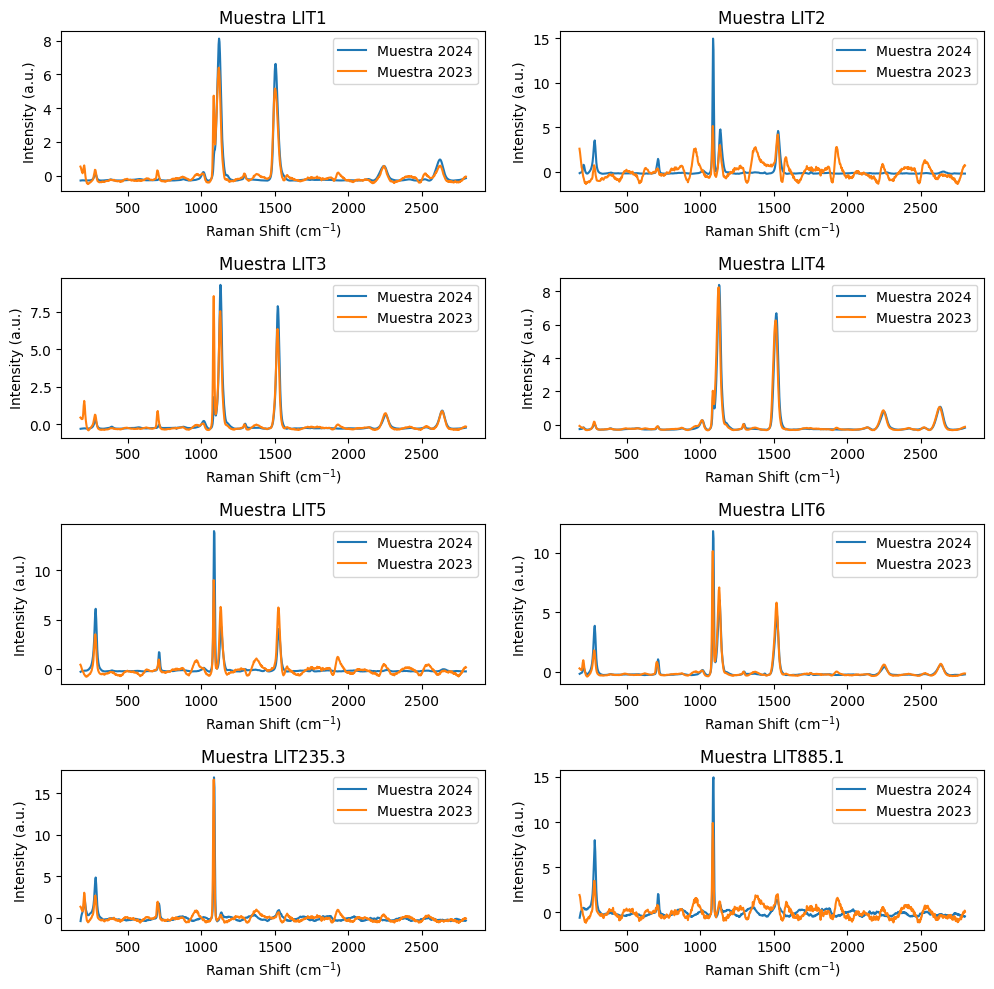

Espectros medios para las muestras sin normalizar


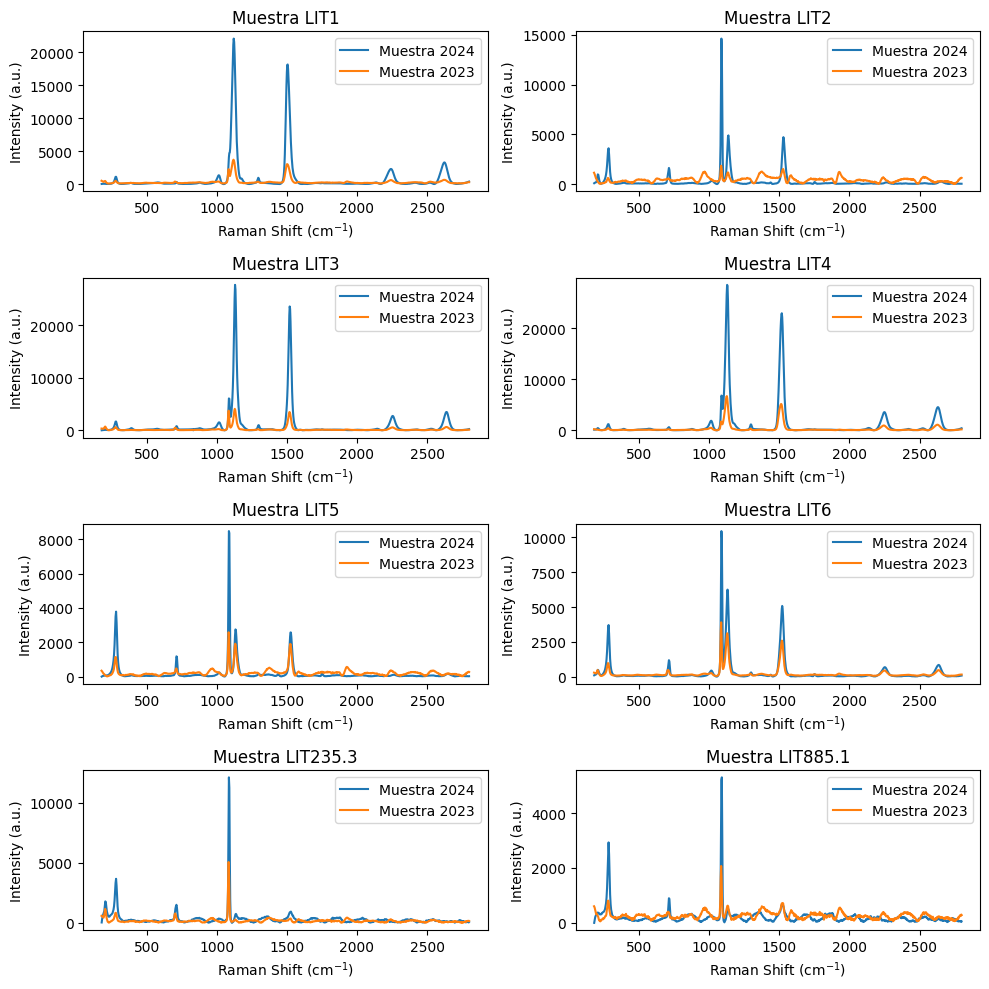

In [13]:
def avg_spectrum_all_8muestras_comp(data1, data2, muestras):

    fig, axes = plt.subplots(4, 2, figsize=(10, 10))

    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        # Datos para 2023
        data_muestra1 = data1[data1.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber1 = data_muestra1.columns.get_level_values(0).astype(float)
        mean_intensity1 = data_muestra1.mean(axis=0)

        # Datos para 2024
        data_muestra2 = data2[data2.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber2 = data_muestra2.columns.get_level_values(0).astype(float)
        mean_intensity2 = data_muestra2.mean(axis=0)

        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber2, mean_intensity2, label=f'Muestra 2024')
        axes[fila, columna].plot(wavenumber1, mean_intensity1, label=f'Muestra 2023')
        
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')

        axes[fila, columna].legend()

    # Ajusta el espaciado entre subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

print('Espectros medios para las muestras normalizados con SNV')
avg_spectrum_all_8muestras_comp(data_sonda_2023_Matlab_snv, data_sonda_2024_Matlab_snv, muestras_ordenadas)
print('Espectros medios para las muestras sin normalizar')
avg_spectrum_all_8muestras_comp(data_sonda_2023_Matlab, data_sonda_2024_Matlab, muestras_ordenadas)

Espectros medios para las muestras normalizados con SNV


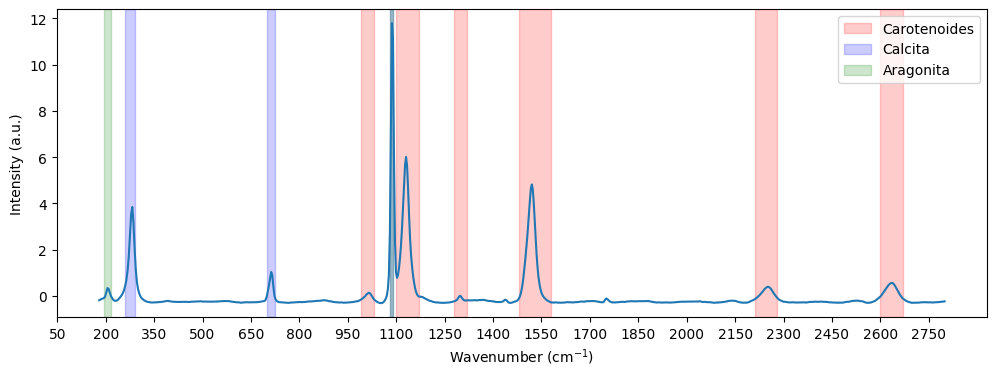

In [10]:
import matplotlib.patches as mpatches
def avg_spectrum (data,
                  muestras):
  #data = pd.concat(dataframes, axis=0)
  #data = create_df(csv_files, path)

  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)


    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}')


    # Define the x ranges
    # x_ranges_polimeros = [[1450, 1680], [1070, 1210], [1285,1315]]
    x_ranges_caro = [[1480,1580],[1100,1170], [1280,1320],[990,1030], [2210,2280], [2600,2670]]
    x_ranges_calcita = [[1080,1090],  [260,290], [700,725]]
    x_ranges_aragonito  = [[195,215], [1080,1090]]
    # Plot the areas


    # Añade las áreas y los nombres de los picos
    for x_range in x_ranges_caro:
            plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='red')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()


    for x_range in x_ranges_calcita:
            plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='blue')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            #plt.text(peak_pos , peak_height + 0.5, round(peak_pos), color='black', ha='center', va='bottom', rotation = 90)

    for x_range in x_ranges_aragonito:
            plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='green')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            #plt.text(peak_pos , peak_height + 0.5, round(peak_pos) , color='black', ha='center', va='bottom', rotation = 90)



  # plt.axvspan(1080,1090, alpha=0.2, color='blue')

  # Define the legend labels and colors
  legend_labels = ['Carotenoides', 'Calcita', 'Aragonita']
  legend_colors = ['red', 'blue', 'green']
  

  # Modify the alpha value of the legend colors
  legend_colors_alpha = [color + '0.2' for color in legend_colors]

  # Create the legend patches with modified alpha values
 # Create the legend patches without modified alpha values
  legend_patches = [mpatches.Patch(color=color, label=label, alpha=0.2) for color, label in zip(legend_colors, legend_labels)]

# Add the legend to the plot
  plt.legend(handles=legend_patches)


  # Add the legend to the plot
  plt.legend(handles=legend_patches)
  # Etiquetas y título para el gráfico
  plt.xlabel("Wavenumber (cm$^{-1}$)")
  plt.ylabel('Intensity (a.u.)')
  plt.title('Bandas')
  plt.xticks(np.arange(50, max(wavenumber)+1, 150), rotation = 0)
  

  plt.show()

print('Espectros medios para las muestras normalizados con SNV')
muestras_ordenadas_2 = ['LIT6']
for i in muestras_ordenadas_2:
  avg_spectrum(data_sonda_2024_Matlab_snv, [i])
